### <font color="green"> RNN Model for Stock prediction using stock data and 300 news Vectors</font>

**Import Libraries**

In [ ]:
#Import Libraries
import math
import time
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as prep
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import GRU
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Get the Stock Data and Visualize**

In [ ]:
#Fetch data from Yahoo finance 
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26') 

#To get the stock data for companies Tesla, AMD and Dis uncomment the respective lines below
#df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#df = web.DataReader('DIS', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98
2016-07-27,6.98,6.68,6.93,6.85,38567300,6.85
2016-07-28,6.98,6.74,6.79,6.82,27515600,6.82


In [ ]:
#Import Vectors Data
newsScores=pd.read_csv('vectorAMD (1).csv')
newsScores.head(3)
len(newsScores)

375

In [ ]:
df1=df.reset_index()
df1.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98


In [ ]:
#Combine Vectors and Stock data
newsScores['date'] = pd.to_datetime(newsScores['date'])
merged_data = pd.merge(left=df1, right=newsScores, left_on='Date', right_on='date') #merge datasets
merged_data.drop(['date'], axis=1,inplace=True) #remove redundant column
merged_data.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,news,vectors,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19,vec20,vec21,vec22,vec23,vec24,vec25,vec26,vec27,vec28,vec29,vec30,...,vec260,vec261,vec262,vec263,vec264,vec265,vec266,vec267,vec268,vec269,vec270,vec271,vec272,vec273,vec274,vec275,vec276,vec277,vec278,vec279,vec280,vec281,vec282,vec283,vec284,vec285,vec286,vec287,vec288,vec289,vec290,vec291,vec292,vec293,vec294,vec295,vec296,vec297,vec298,vec299
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84,Wall St set open marginally higher,[-0.00675456 0.04950969 -0.00374349 0.153157...,-0.006755,0.049510,-0.003743,0.153158,0.038737,-0.041138,-0.033661,0.019124,0.147257,0.001180,-0.105347,0.007289,0.056661,-0.098877,-0.070923,0.034261,0.038940,-0.061869,0.106600,-0.000252,0.052063,-0.004333,-0.005534,-0.024821,0.091878,0.020040,-0.186686,0.099040,0.017002,-0.003571,-0.018107,...,0.125407,-0.013260,0.116936,0.032247,0.062907,-0.001109,-0.089032,-0.139933,-0.040110,-0.041819,-0.010478,0.058319,0.064728,-0.112712,0.184326,-0.138774,-0.089630,-0.074972,0.001923,0.153361,-0.100138,0.048106,-0.022400,0.102061,0.116781,0.027181,-0.114197,0.088521,0.039551,0.088521,-0.002116,0.078288,-0.052124,0.033813,-0.033325,0.022013,-0.020754,-0.114777,-0.044983,-0.006185
1,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84,Futures edge day Dow snap winning streak,[-7.16247559e-02 1.28740584e-02 -4.34810109e-...,-0.071625,0.012874,-0.043481,-0.045785,0.073172,-0.133963,-0.076765,-0.097935,0.143834,0.140839,0.068499,0.118408,0.123587,0.048139,-0.124198,0.015363,0.004900,0.009521,0.197113,-0.267648,-0.012660,0.116547,0.102225,-0.078230,0.082258,-0.027161,-0.037388,0.084577,0.085062,0.037694,0.031808,...,0.022845,0.017299,-0.022112,-0.023612,0.128979,0.093253,-0.015459,-0.120065,-0.004395,-0.003435,0.010585,0.040739,0.010568,0.021415,0.060924,-0.025029,-0.093000,-0.037362,-0.051505,0.117571,0.072492,-0.014143,0.061458,0.059082,-0.100900,-0.202724,-0.168876,0.131557,0.032296,-0.043980,-0.027771,0.012347,-0.107527,0.016741,0.115827,0.000768,-0.069824,0.001081,-0.082310,-0.038910
2,2016-08-03,6.45,6.15,6.18,6.30,23807800,6.30,FBI took month warn Democrats suspected Russia...,[ 1.18029788e-01 2.70996094e-02 -1.37069700e-...,0.118030,0.027100,-0.013707,-0.010608,-0.149756,0.010522,0.038037,0.028518,0.080981,0.124463,0.050198,-0.138135,0.008740,0.056726,-0.089087,0.099704,-0.057178,0.077393,-0.063672,-0.130334,0.026843,0.048009,0.056763,0.012793,0.089478,0.028320,-0.028674,-0.039209,-0.020105,0.067607,0.050195,...,0.023065,0.002167,-0.073209,0.093869,0.087354,0.105473,-0.263623,0.002339,-0.102244,-0.028687,0.036462,0.052673,-0.000244,-0.007056,0.104907,0.006046,0.027747,-0.113159,0.054779,-0.001950,-0.011276,-0.008740,-0.076941,0.092209,0.006062,-0.150623,-0.108887,0.008002,-0.006976,-0.035767,-0.045065,-0.012268,-0.039130,0.021719,-0.004346,-0.054996,-0.050867,-0.047729,0.040039,0.047705


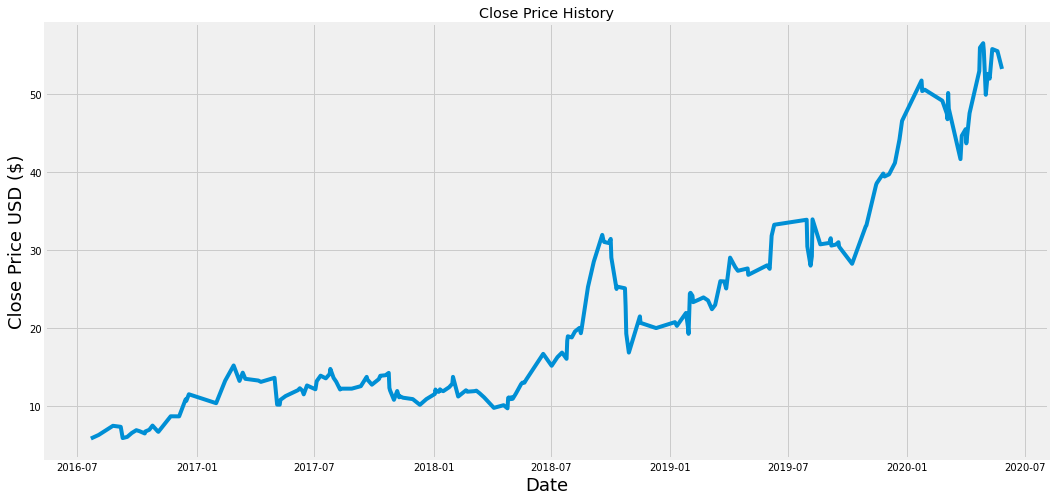

In [ ]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(merged_data['Date'],merged_data['Close'] )
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Data Preprocessing**

In [ ]:
#Remove extra coloumns
type(merged_data)
data = merged_data
del data['Volume']
del data['Adj Close']
del data['news']
del data ['vectors']
data.head(3)

,Close,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19,vec20,vec21,vec22,vec23,vec24,vec25,vec26,vec27,vec28,vec29,vec30,vec31,vec32,vec33,vec34,vec35,vec36,vec37,vec38,...,vec260,vec261,vec262,vec263,vec264,vec265,vec266,vec267,vec268,vec269,vec270,vec271,vec272,vec273,vec274,vec275,vec276,vec277,vec278,vec279,vec280,vec281,vec282,vec283,vec284,vec285,vec286,vec287,vec288,vec289,vec290,vec291,vec292,vec293,vec294,vec295,vec296,vec297,vec298,vec299
0,5.84,-0.006755,0.049510,-0.003743,0.153158,0.038737,-0.041138,-0.033661,0.019124,0.147257,0.001180,-0.105347,0.007289,0.056661,-0.098877,-0.070923,0.034261,0.038940,-0.061869,0.106600,-0.000252,0.052063,-0.004333,-0.005534,-0.024821,0.091878,0.020040,-0.186686,0.099040,0.017002,-0.003571,-0.018107,0.041911,0.035299,-0.080811,-0.110840,-0.126506,0.039408,0.086792,-0.016764,...,0.125407,-0.013260,0.116936,0.032247,0.062907,-0.001109,-0.089032,-0.139933,-0.040110,-0.041819,-0.010478,0.058319,0.064728,-0.112712,0.184326,-0.138774,-0.089630,-0.074972,0.001923,0.153361,-0.100138,0.048106,-0.022400,0.102061,0.116781,0.027181,-0.114197,0.088521,0.039551,0.088521,-0.002116,0.078288,-0.052124,0.033813,-0.033325,0.022013,-0.020754,-0.114777,-0.044983,-0.006185
1,5.84,-0.071625,0.012874,-0.043481,-0.045785,0.073172,-0.133963,-0.076765,-0.097935,0.143834,0.140839,0.068499,0.118408,0.123587,0.048139,-0.124198,0.015363,0.004900,0.009521,0.197113,-0.267648,-0.012660,0.116547,0.102225,-0.078230,0.082258,-0.027161,-0.037388,0.084577,0.085062,0.037694,0.031808,0.075928,0.094060,-0.041207,-0.008092,0.003680,-0.051008,-0.099078,-0.023546,...,0.022845,0.017299,-0.022112,-0.023612,0.128979,0.093253,-0.015459,-0.120065,-0.004395,-0.003435,0.010585,0.040739,0.010568,0.021415,0.060924,-0.025029,-0.093000,-0.037362,-0.051505,0.117571,0.072492,-0.014143,0.061458,0.059082,-0.100900,-0.202724,-0.168876,0.131557,0.032296,-0.043980,-0.027771,0.012347,-0.107527,0.016741,0.115827,0.000768,-0.069824,0.001081,-0.082310,-0.038910
2,6.30,0.118030,0.027100,-0.013707,-0.010608,-0.149756,0.010522,0.038037,0.028518,0.080981,0.124463,0.050198,-0.138135,0.008740,0.056726,-0.089087,0.099704,-0.057178,0.077393,-0.063672,-0.130334,0.026843,0.048009,0.056763,0.012793,0.089478,0.028320,-0.028674,-0.039209,-0.020105,0.067607,0.050195,-0.058398,-0.035660,0.024475,-0.013544,-0.054468,0.000195,-0.011792,-0.033543,...,0.023065,0.002167,-0.073209,0.093869,0.087354,0.105473,-0.263623,0.002339,-0.102244,-0.028687,0.036462,0.052673,-0.000244,-0.007056,0.104907,0.006046,0.027747,-0.113159,0.054779,-0.001950,-0.011276,-0.008740,-0.076941,0.092209,0.006062,-0.150623,-0.108887,0.008002,-0.006976,-0.035767,-0.045065,-0.012268,-0.039130,0.021719,-0.004346,-0.054996,-0.050867,-0.047729,0.040039,0.047705


In [ ]:

#Converting the dataframe to a numpy array
new_data = merged_data.filter(['Close']).values
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
newScaler = MinMaxScaler(feature_range=(0, 1))
new_scaled_date = newScaler.fit_transform(new_data)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i])
  y_train.append(train_data[i,0])
print(x_train[0])
print(y_train[0])

[[0.         0.59275856 0.61804947 ... 0.38343401 0.18166932 0.65643125]
 [0.         0.43548983 0.53037227 ... 0.62738906 0.1004729  0.58783265]
 [0.00908194 0.89528078 0.56441718 ... 0.52461123 0.36661356 0.76939611]
 ...
 [0.12221124 0.58306645 0.18765217 ... 0.49881388 0.27332271 0.51773073]
 [0.12714708 0.51485524 0.53587079 ... 0.61568473 0.2594707  0.49352976]
 [0.12082921 0.14856306 0.47410375 ... 0.51701948 0.23126723 0.4291426 ]]
0.11174727891212821


In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#test_data = scaled_data[training_data_len: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , 0 ] 

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i])
print(x_test[0])

[[0.49457055 0.5060425  0.44907975 ... 0.55005783 0.28305673 0.58844677]
 [0.50503453 0.68803969 0.77088811 ... 0.45949468 0.25044255 0.45918628]
 [0.50503453 0.54451995 0.57817217 ... 0.65744816 0.23402372 0.44831116]
 ...
 [0.41401774 0.69972531 0.66259291 ... 0.50766111 0.275624   0.63217901]
 [0.43810464 0.48955851 0.58737949 ... 0.56107988 0.35243406 0.89390993]
 [0.42922012 0.69397087 0.31736293 ... 0.39939168 0.23889184 0.74846469]]


In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
print(x_test.shape)

(73, 60, 301)


**RNN**

In [ ]:
#Model creation
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another GRU layer
    model.add(GRU(units=512, return_sequences=True,input_shape=(x_train.shape[1], 301)))
    model.add(Dropout(0.2))

    model.add(GRU(units=256))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
#Test and Train data shape
print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (232, 60, 301)
y_train (232,)
X_test (73, 60, 301)
y_test (73,)


In [ ]:
#Compiling the model
window = 60
model = build_model([1, window, 100, 1])

Compilation Time :  0.0072650909423828125


In [ ]:
#Model training
model.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=1)

232/232 [==============================] - 54s 232ms/step - loss: 0.9632 - accuracy: 0.0000e+00


In [ ]:
#Test the train model using test data
predictions = model.predict(x_test) 
predictions = newScaler.inverse_transform(predictions)
print(predictions)

[[16.337416]
 [16.39879 ]
 [16.389362]
 [16.307943]
 [16.32894 ]
 [16.315592]
 [16.396633]
 [16.365515]
 [16.330875]
 [16.328453]
 [16.38423 ]
 [16.332777]
 [16.392826]
 [16.398794]
 [16.405148]
 [16.333416]
 [16.345484]
 [16.403149]
 [16.37759 ]
 [16.361168]
 [16.390345]
 [16.333717]
 [16.373566]
 [16.398722]
 [16.378626]
 [16.39464 ]
 [16.289309]
 [16.31339 ]
 [16.236753]
 [16.256723]
 [16.336426]
 [16.361862]
 [16.30569 ]
 [16.41716 ]
 [16.432842]
 [16.375275]
 [16.387812]
 [16.371838]
 [16.380978]
 [16.335756]
 [16.374233]
 [16.39203 ]
 [16.38755 ]
 [16.40798 ]
 [16.30268 ]
 [16.302633]
 [16.243994]
 [16.264904]
 [16.353565]
 [16.405478]
 [16.373596]
 [16.408337]
 [16.379318]
 [16.397518]
 [16.357662]
 [16.329985]
 [16.319714]
 [16.429478]
 [16.389675]
 [16.362068]
 [16.419954]
 [16.429857]
 [16.421444]
 [16.42905 ]
 [16.365076]
 [16.28539 ]
 [16.311073]
 [16.414663]
 [16.409264]
 [16.429873]
 [16.46818 ]
 [16.338037]
 [16.380142]]


In [ ]:
#Calculating rmse
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

26.012418361003874

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


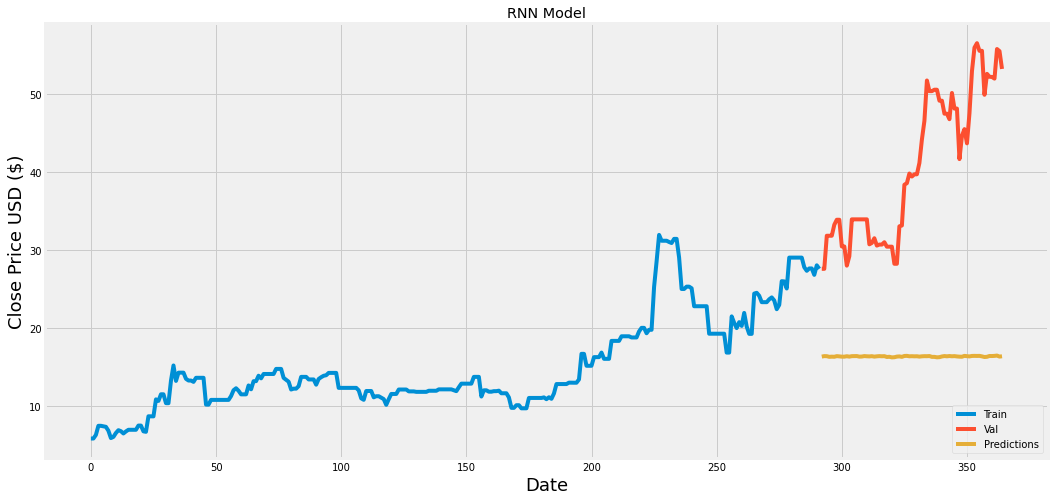

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('RNN Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()